# 04. Transfer Learning in TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existig neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [1]:
# Are we using a gpu
!nvidia-smi

Thu Oct 24 19:26:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060        Off |   00000000:01:00.0  On |                  N/A |
| 25%   55C    P0             36W /  170W |     476MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Downloading and becoming one with the data

In [2]:
!rm -rf 10_food_classes_10_percent*

# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zipref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zipref.extractall()
zipref.close()

!rm -rf __MACOSX*

--2024-10-24 19:26:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.209.219, 216.58.211.251, 2a00:1450:4026:805::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.209.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  31.2MB/s    in 5.5s    

2024-10-24 19:27:00 (29.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## 2. Creating data loaders (preparing the data)

We'll use th `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Setup data inputs

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training images")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
print("Validation images")
test_data_10_percent = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Training images
Found 750 images belonging to 10 classes.
Validation images
Found 2500 images belonging to 10 classes.


## 3. Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the mose popular callbacks.

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## 4. Creating models with TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: [https://tfhub.dev/](https://tfhub.dev/)

Browsing kaggle (tfhub) page and sorting for image classification, we found the following feature vector model link: https://www.kaggle.com/models/tensorflow/efficientnet/tensorFlow2/b0-feature-vector/1

https://www.kaggle.com/models/google/resnet-v2/tensorFlow2/50-feature-vector/1

In [6]:
# Let's compare the following two models

# ResNet v2
resnet_url = "https://kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/1"
# EfficientNet
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"


In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL
        num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10.

    Return:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as Keras Layer
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False,
        name="feature_extraction_layer",
        input_shape=IMAGE_SHAPE+(3,)
    )
    # Create our own model
    return tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(
            num_classes, 
            activation="softmax", 
            name="output_layer"
        )
    ])

### 4.1 Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Creating resnet model
resnet_model = create_model(resnet_url)
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [10]:
# Compile our resnet model
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [11]:
# Fit our resnet model
resnet_history_1 = resnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[create_tensorboard_callback(
        dir_name="tensorflow_hub",
        experiment_name="resnet50v2"
    )]
)

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20241024-192706
Epoch 1/5
24/24 [==============================] - 14s 346ms/step - loss: 1.9272 - accuracy: 0.3347 - val_loss: 1.1957 - val_accuracy: 0.6268
Epoch 2/5
24/24 [==============================] - 7s 278ms/step - loss: 0.8673 - accuracy: 0.7467 - val_loss: 0.8651 - val_accuracy: 0.7188
Epoch 3/5
24/24 [==============================] - 7s 279ms/step - loss: 0.6085 - accuracy: 0.8200 - val_loss: 0.7523 - val_accuracy: 0.7644
Epoch 4/5
24/24 [==============================] - 7s 279ms/step - loss: 0.4571 - accuracy: 0.8773 - val_loss: 0.7121 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 7s 280ms/step - loss: 0.3740 - accuracy: 0.9107 - val_loss: 0.6828 - val_accuracy: 0.7756


In [12]:
# Let's create a function to plot our loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history, title=""):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    
    fig = plt.figure(figsize=(10,5))
    fig.suptitle(title)
    
    # Plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="Training_loss")
    plt.plot(epochs, val_loss, label="Validatio_ loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="Training_accuracy")
    plt.plot(epochs, val_accuracy, label="Validation_accuracy")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

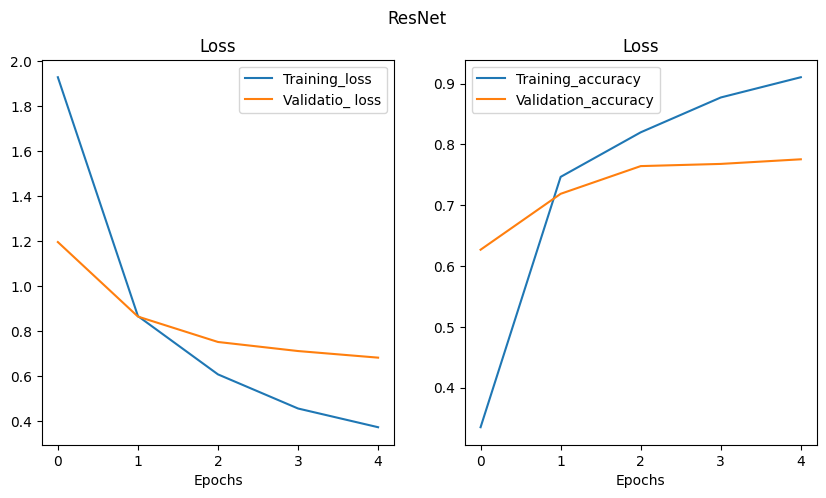

In [13]:
plot_loss_curves(resnet_history_1, title="ResNet")

### 4.2 Creating and testing EfficientNetb0 feature extraction

In [14]:
# Creating our EfficientNet model
efficientnet_model = create_model(efficientnet_url)
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [15]:
# Compile our model
efficientnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [16]:
# Fit efficientnet model
efficientnet_history_1 = efficientnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[create_tensorboard_callback(
        dir_name="tensorflow_hub",
        experiment_name="efficientnetb0"
    )]
)

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20241024-192800
Epoch 1/5
24/24 [==============================] - 19s 260ms/step - loss: 1.8642 - accuracy: 0.4160 - val_loss: 1.3059 - val_accuracy: 0.7120
Epoch 2/5
24/24 [==============================] - 5s 194ms/step - loss: 1.0626 - accuracy: 0.7707 - val_loss: 0.8719 - val_accuracy: 0.8084
Epoch 3/5
24/24 [==============================] - 5s 194ms/step - loss: 0.7577 - accuracy: 0.8213 - val_loss: 0.6981 - val_accuracy: 0.8432
Epoch 4/5
24/24 [==============================] - 5s 194ms/step - loss: 0.6099 - accuracy: 0.8600 - val_loss: 0.6066 - val_accuracy: 0.8612
Epoch 5/5
24/24 [==============================] - 5s 195ms/step - loss: 0.5137 - accuracy: 0.8880 - val_loss: 0.5535 - val_accuracy: 0.8652


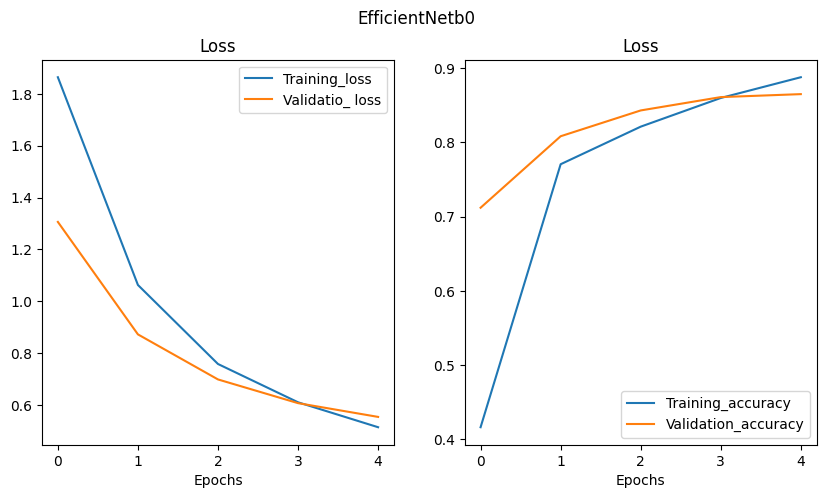

In [17]:
# Plot loss curves
plot_loss_curves(efficientnet_history_1, title="EfficientNetb0")

In [18]:
resnet_model.summary(), efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                       

(None, None)

In [19]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

### Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model 1000 ImageNet classes, none of your own)
* **Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## 5. Comparing our models using tensorboard

> **Note:** When you upload things to TensorBoard.dev, your experiements are public. So if you are running private experiements do not upload them to TensorBoard.dev

In [20]:
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs Resnet50V2" --description "Comparing EfficientNetB0 and Resnet50V2"


In [22]:
# Locally
#%load_ext tensorboard
#%tensorboard --logdir tensorflow_hub

In [23]:
!rm -rf tensorflow_hub/
!rm -rf 10_food_classes_10_percent*